In [41]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pandas as pd
import pathlib

In [42]:
data_dir = pathlib.Path('data/train/').with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

28709


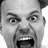

In [43]:
angry = list(data_dir.glob('angry/*'))
disgust = list(data_dir.glob('disgust/*'))
fear = list(data_dir.glob('fear/*'))
happy = list(data_dir.glob('happy/*'))
neutral = list(data_dir.glob('neutral/*'))
sad = list(data_dir.glob('sad/*'))
surprise = list(data_dir.glob('surprise/*'))

PIL.Image.open(str(angry[0]))
# PIL.Image.open(str(fear[0]))

In [44]:
batch_size = 32
img_height = 224
img_width = 224

In [45]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale')

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale')

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [46]:
# Save class names for later use
import json

class_names = train_ds.class_names
print(class_names)

with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

# To load files
def load_class_names():
    with open('class_names.json', 'r') as f:
        return json.load(f)
    
# Example usage : predictd_class_name = class_names[predicted_index]

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [47]:
# Normalization is made in the layers - This code is therefore useless
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [48]:
# Important - Set weights as the dataset is imbalanced
from sklearn.utils import class_weight

train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_labels),
    y = train_labels
)

class_weight_dict = dict(enumerate(class_weights))

print("Class Weight Dictionary:", class_weight_dict)

Class Weight Dictionary: {0: np.float64(1.0158337019018133), 1: np.float64(9.593984962406015), 2: np.float64(0.9982180885740363), 3: np.float64(0.5650323501193141), 4: np.float64(0.836173001310616), 5: np.float64(0.8518024032042724), 6: np.float64(1.2989480827960638)}


2025-10-15 20:06:14.272465: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# # Ancient code for training from scratch - complete sequential without any transfer learning
# num_classes = len(train_ds.class_names)

# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(num_classes)
# ])

# model.compile(
#   optimizer='adam',
#   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=['accuracy'])

In [49]:
# ImageNet needs input in three channels, because it was trained on RGB images. This is why we convert the grayscale images to RGB by repeating the single channel three times.
# Even if the images are already grayscaled in the dataset, this conversion ensures that there is three channels with the same values to prevent any noise.
def convert_grayscale_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

# Convert the whole dataset
train_ds = train_ds.map(convert_grayscale_to_rgb)
val_ds = val_ds.map(convert_grayscale_to_rgb)


In [ ]:
# Optimization for performance
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [53]:
num_classes = len(class_names)

# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
], name="data_augmentation")

In [54]:
# Setting up MobileNetV2 as base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (img_width, img_height, 3), # 3 for RGB channels
    include_top = False,
    weights = "imagenet"
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [55]:
# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)), # Simple definition of input shape
    data_augmentation,
    tf.keras.layers.Rescaling(1./127.5, offset=-1), # MobileNetV2 needs inputs in the range [-1, 1]
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, )
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

/home/vlrr/miniconda3/envs/ml/lib/python3.13/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [56]:
# Model training
# Implement early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Save model periodically
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

# Training
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  class_weight=class_weight_dict,
  callbacks=[early_stopping_callback, model_checkpoint_callback]
)

Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, None, None, 224, 224, 3), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (None, None, None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, None, None, 224, 224, 3), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:
sample_img_path = fear[20]
PIL.Image.open(str(sample_img_path))

In [ ]:

img = tf.keras.utils.load_img(
    str(sample_img_path),
    target_size=(img_width, img_height),
    color_mode="grayscale"
)

# img_array = np.array(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, 0)  # add batch dimension

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

predicted_index = np.argmax(score)
predicted_class_name = train_ds.class_names[predicted_index]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(predicted_class_name, 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
This image most likely belongs to fear with a 81.92 percent confidence.
